## House Prices- Advanced Regression Techniques

Predict sales prices and practice feature engineering, RFs, and gradient boosting

## Project Description

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

This competition challenges you to predict the final price of each home.

## File Descriptions

train.csv - the training set

test.csv - the test set

data_description.txt - full description of each column

sample_submission.csv - a benchmark submission from a linear regression on year and month of sale, lot square footage and number of bedrooms

Housing_Prices.ipynb - my program with detailed explanations of each step

DisariB_Final.csv - output file

#### Part 1: Exploratory Data Analysis

    Importing libraries

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_val_score
from scipy.stats import norm
from scipy import stats 
import warnings
warnings.filterwarnings("ignore")

    Loading datasets

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print("Shape of train dataset:", train.shape)
print("Shape of test dataset:", test.shape)

train.head()

Shape of train dataset: (1460, 81)
Shape of test dataset: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


    Visualizing house prices distribution

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

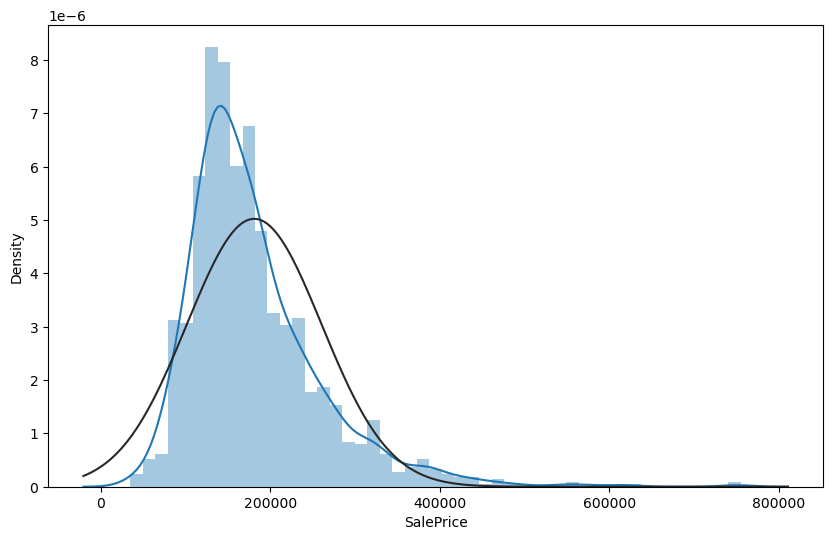

In [3]:
plt.figure(figsize=[10,6])
sns.distplot(train.SalePrice, fit=norm)

    Log Transformation

I am using a log transformation to make it more normally distributed since it is currently right-skewed

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

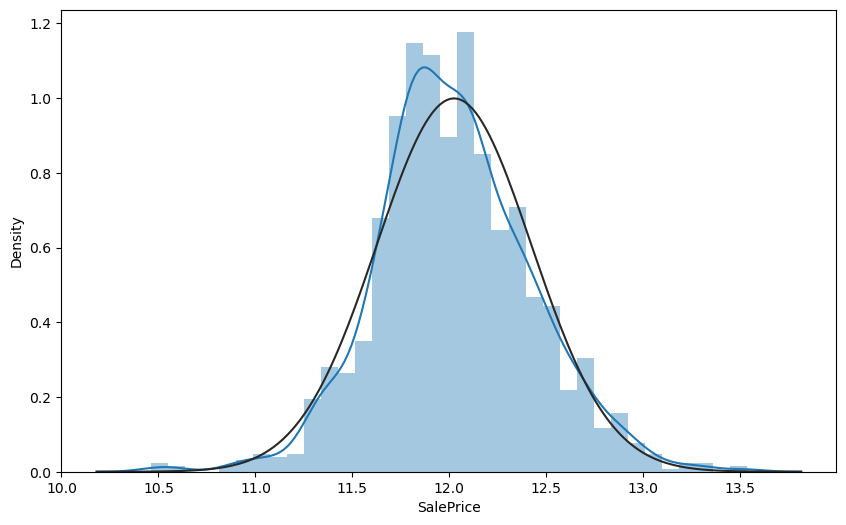

In [4]:
plt.figure(figsize=[10,6])
sns.distplot(np.log(train.SalePrice), fit=norm)

    Visualizing feature correlation with SalePrice

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
BedroomAbvGr    0.168213
ScreenPorch     0.111447
Name: SalePrice, dtype: float64

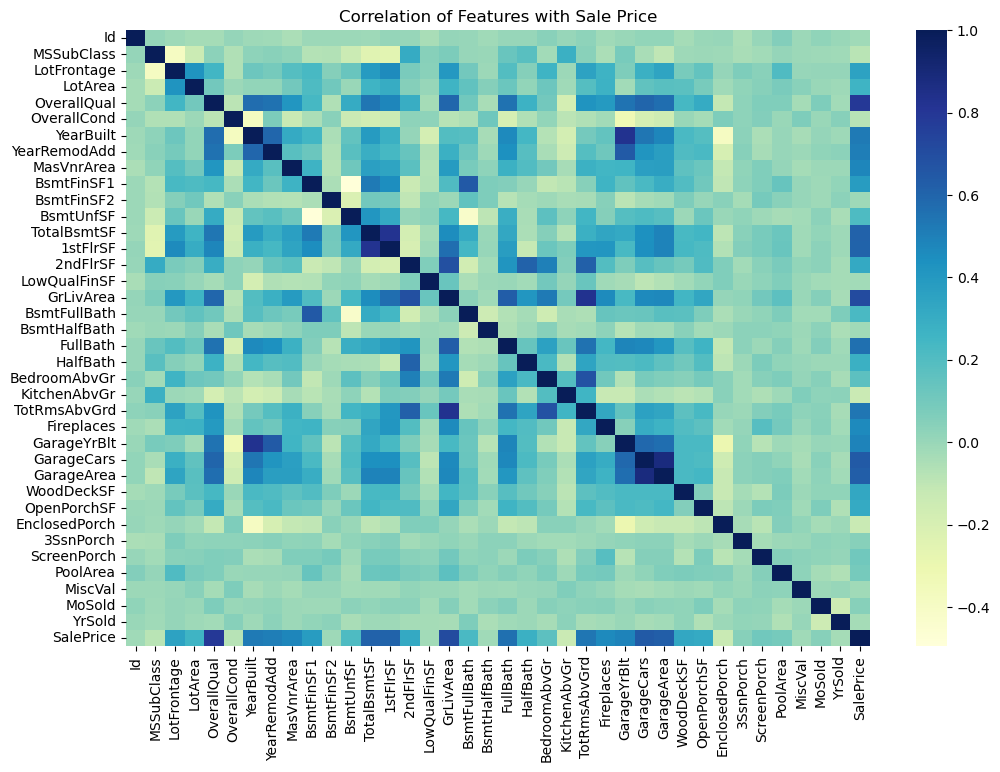

In [5]:
# Heatmap for visualization
correlation= train.corr()
plt.figure(figsize=[12,8])
plt.title('Correlation of Features with Sale Price')
sns.heatmap(correlation,cmap="YlGnBu")

# List to see correlation values
correlation= train.corr()
correlation=correlation['SalePrice'].sort_values(ascending=False)
pos_correlation=correlation.head(25)
pos_correlation

    Visualizing 3 features with the highest correlation with SalePrice

1. OverallQual

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

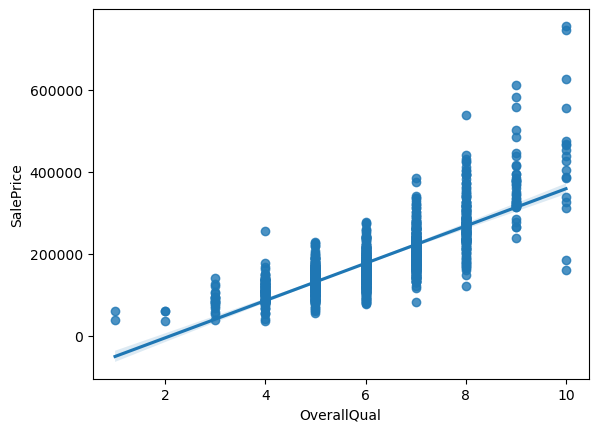

In [6]:
sns.regplot(train['OverallQual'], train['SalePrice'])

2. GrLivArea

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

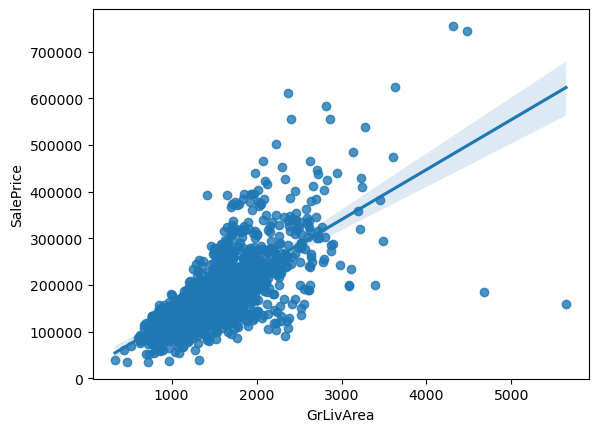

In [7]:
sns.regplot(train['GrLivArea'], train['SalePrice'])

3. GarageCars

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>

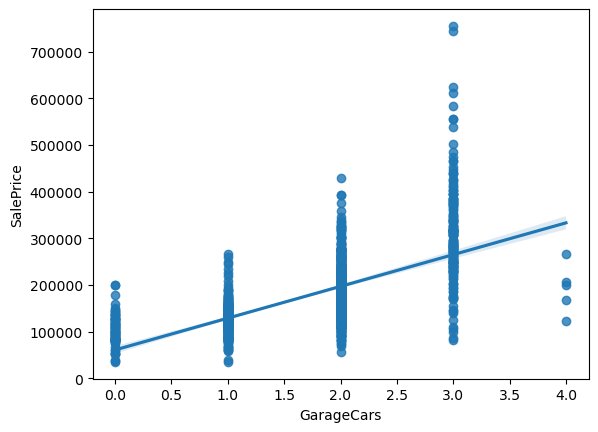

In [8]:
sns.regplot(train['GarageCars'], train['SalePrice'])

#### Part 2: Data Cleaning

    Removing Outliers

In [9]:
print("Train Shape Before Dropping Outliers:",train.shape)

train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index, inplace=True)
train.drop(train[(train['GarageArea']>1200) & (train['SalePrice']<100000)].index, inplace=True)
train.drop(train[(train['TotalBsmtSF']>6000) & (train['SalePrice']<200000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

print("Train Shape After Dropping Outliers:",train.shape)

Train Shape Before Dropping Outliers: (1460, 81)
Train Shape After Dropping Outliers: (1457, 81)


    Handling Missing Values

In [10]:
data= pd.concat([train.drop(['SalePrice'], axis=1), test])

Visualizing the amount of missing values in the first 30 columns

<AxesSubplot:>

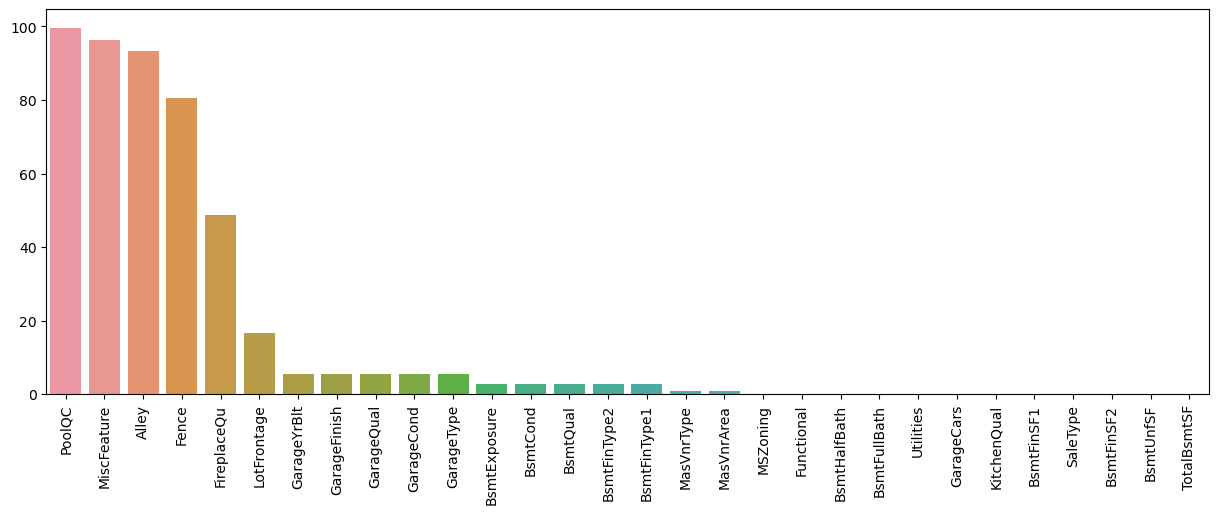

In [11]:
xx = (data.isnull().sum())/len(data)*100
xx = xx.sort_values(ascending=False).head(30)

plt.figure(figsize=(15, 5))
plt.xticks(rotation="90")
sns.barplot(xx.keys(), xx)

Finding the percentage of missing values in the columns

In [12]:
total=data.isnull().sum().sort_values(ascending=False)
percent=((data.isnull().sum()/data.isnull().count())*100).sort_values(ascending=False)
missing= pd.concat([total,percent], axis=1, join='outer', keys=['Total missing count', 'Percentage '])
missing.head(34)

,Total missing count,Percentage
PoolQC,2907,99.691358
MiscFeature,2812,96.433471
Alley,2718,93.209877
Fence,2345,80.418381
FireplaceQu,1419,48.662551
LotFrontage,486,16.666667
GarageYrBlt,159,5.452675
GarageFinish,159,5.452675
GarageQual,159,5.452675
GarageCond,159,5.452675


##### Garage

There are a few columns that specify different aspects of the garage, and they all have the same number of missing values, which indicates that those houses don't have a garage. I am going to fill in those missing values with "None"

In [13]:
train['GarageQual'].fillna('None', inplace=True)
test['GarageQual'].fillna('None', inplace=True)

train['GarageFinish'].fillna('None', inplace=True)
test['GarageFinish'].fillna('None', inplace=True)

train['GarageYrBlt'].fillna('None', inplace=True)
test['GarageYrBlt'].fillna('None', inplace=True)

train['GarageType'].fillna('None', inplace=True)
test['GarageType'].fillna('None', inplace=True)

train['GarageCond'].fillna('None', inplace=True)
test['GarageCond'].fillna('None', inplace=True)

test.loc[test['Id']==2577, 'GarageType']='None'

test['GarageCars'].fillna(0, inplace=True)
test['GarageArea'].fillna(0, inplace=True)

##### Basement

There's only one missing value in TotalBsmtSF, but many more missing values in the other columns relating to basements, which means that there are houses with basements that don't have available data for those columns.

In [14]:
# Looking at the rows with a basement but no basement condition
data[(data['TotalBsmtSF']!=0) & 
(data['BsmtCond'].isnull()==True)][['Id','TotalBsmtSF','BsmtCond','BsmtQual','BsmtExposure',
                                    'BsmtFinType1','BsmtFinSF1','BsmtUnfSF']]

# Filling BsmtCond null values with BsmtQual values and the rest with None since they don't have a basement
test.loc[test['Id']==2041, 'BsmtCond']='Gd'
test.loc[test['Id']==2186, 'BsmtCond']='TA'
test.loc[test['Id']==2525, 'BsmtCond']='TA'
train['BsmtCond'].fillna('None', inplace=True)
test['BsmtCond'].fillna('None', inplace=True)

# Looking at the rows with a basement but no basement condition again
data[(data['TotalBsmtSF']!=0) & 
(data['BsmtCond'].isnull()==True)][['Id','TotalBsmtSF','BsmtCond','BsmtQual','BsmtExposure',
                                    'BsmtFinType1','BsmtFinSF1','BsmtUnfSF']]


,Id,TotalBsmtSF,BsmtCond,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF
580,2041,1426.0,NaN,Gd,Mn,GLQ,1044.0,0.0
660,2121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
725,2186,1127.0,NaN,TA,No,BLQ,1033.0,94.0
1064,2525,995.0,NaN,TA,Av,ALQ,755.0,240.0


In [15]:
# Filling BsmtExposre null values with values of BsmtQual and others with None
train.loc[train['Id']==949, 'BsmtExposure']='Gd'
test.loc[test['Id']==1488, 'BsmtExposure']='Gd'
test.loc[test['Id']==2349, 'BsmtExposure']='Gd'
train['BsmtExposure'].fillna('None', inplace=True)
test['BsmtExposure'].fillna('None', inplace=True)

data[(data['TotalBsmtSF']!=0) & 
(data['BsmtQual'].isnull()==True)][['Id','TotalBsmtSF','BsmtQual','BsmtCond','BsmtExposure',
                                    'BsmtFinType1','BsmtFinSF1','BsmtUnfSF']]

,Id,TotalBsmtSF,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF
660,2121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
757,2218,173.0,NaN,Fa,No,Unf,0.0,173.0
758,2219,356.0,NaN,TA,No,Unf,0.0,356.0


In [16]:
# Filling BsmtQual null values with values of BsmtCond and others with None
test.loc[test['Id']==2218, 'BsmtQual']='Fa'
test.loc[test['Id']==2219, 'BsmtQual']='TA'
train['BsmtQual'].fillna('None', inplace=True)
test['BsmtQual'].fillna('None', inplace=True)

data[(data['TotalBsmtSF']!=0) & 
(data['BsmtFinType1'].isnull()==True)][['Id','TotalBsmtSF','BsmtQual','BsmtCond','BsmtExposure',
                                        'BsmtFinType1','BsmtFinSF1','BsmtUnfSF']]

,Id,TotalBsmtSF,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF
660,2121,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Filling other Basement features missing values with None or 0
train['BsmtFinType1'].fillna('None', inplace=True)
test['BsmtFinType1'].fillna('None', inplace=True)
test['BsmtFinSF1'].fillna(0, inplace=True)
train['BsmtFinType2'].fillna('None', inplace=True)
test['BsmtFinType2'].fillna('None', inplace=True)
test['BsmtUnfSF'].fillna(0, inplace=True)
test['TotalBsmtSF'].fillna(0, inplace=True)

test['BsmtFullBath'].fillna(0, inplace=True)
test['BsmtHalfBath'].fillna(0, inplace=True)

test['BsmtFinSF1'].fillna(0, inplace=True)
test['BsmtFinSF2'].fillna(0, inplace=True)

In [18]:
# Updating remaining columns with missing values to be None or 0

train['FireplaceQu'].fillna('None', inplace=True)
test['FireplaceQu'].fillna('None', inplace=True)

train.loc[train['LotFrontage'].isnull()==True, 'LotFrontage']= train['LotFrontage'].mean()
test.loc[test['LotFrontage'].isnull()==True, 'LotFrontage']= test['LotFrontage'].mean()

train['MasVnrType'].fillna('None', inplace=True)
test['MasVnrType'].fillna('None', inplace=True)

train['MasVnrArea'].fillna(0, inplace=True)
test['MasVnrArea'].fillna(0, inplace=True)

train['PoolQC'].fillna('None', inplace=True)
test['PoolQC'].fillna('None', inplace=True)

train['MiscFeature'].fillna('None', inplace=True)
test['MiscFeature'].fillna('None', inplace=True)

train['Alley'].fillna('None', inplace=True)
test['Alley'].fillna('None', inplace=True)

train['Fence'].fillna('None', inplace=True)
test['Fence'].fillna('None', inplace=True)

train['MSZoning'].fillna('RL', inplace=True)
test['MSZoning'].fillna('RL', inplace=True)

train['Electrical'].fillna('SBrkr', inplace=True)
test['Functional'].fillna('Typ', inplace=True)
test['SaleType'].fillna('WD', inplace=True)
test['Exterior1st'].fillna('VinylSd', inplace=True)
test['KitchenQual'].fillna('TA', inplace=True)
test['Exterior2nd'].fillna('VinylSd', inplace=True)

In [19]:
train.drop('Utilities', axis=1, inplace=True)
test.drop('Utilities', axis=1, inplace=True)

Checking if I have any missing values left

In [20]:
print("Train dataset:\n",train.isnull().sum().sort_values(ascending=False).head(25))
print("\n\nTest dataset:\n",test.isnull().sum().sort_values(ascending=False).head(25))

Train dataset:
 Id               0
MSSubClass       0
GarageYrBlt      0
GarageType       0
FireplaceQu      0
Fireplaces       0
Functional       0
TotRmsAbvGrd     0
KitchenQual      0
KitchenAbvGr     0
BedroomAbvGr     0
HalfBath         0
FullBath         0
BsmtHalfBath     0
BsmtFullBath     0
GrLivArea        0
LowQualFinSF     0
2ndFlrSF         0
1stFlrSF         0
GarageFinish     0
GarageCars       0
GarageArea       0
PoolQC           0
SaleCondition    0
SaleType         0
dtype: int64


Test dataset:
 Id              0
BedroomAbvGr    0
GarageType      0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
HalfBath        0
GarageFinish    0
FullBath        0
BsmtHalfBath    0
BsmtFullBath    0
GrLivArea       0
LowQualFinSF    0
2ndFlrSF        0
1stFlrSF        0
GarageYrBlt     0
GarageCars      0
CentralAir      0
PoolArea        0
SaleType        0
YrSold          0
MoSold          0
dtype: int64


#### Part 3: Feature Engineering

In [21]:
train['renovated']= 1
train.loc[(train['YearBuilt']!=train['YearRemodAdd']),'renovated' ]=0
test['renovated']= 1
test.loc[(test['YearBuilt']!=test['YearRemodAdd']),'renovated' ]=0

train['Total_porch']= (train['OpenPorchSF'])+train['ScreenPorch']+train['3SsnPorch']
train['BsmtFinSF_total']= (train['BsmtFinSF1']**2)+train['BsmtFinSF2']
train['Bath']= (train['FullBath']**2)+ train['HalfBath']
train['BsmtBath']= (train['BsmtFullBath'])+train['BsmtHalfBath']
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
train['Total_garage']= (train['GarageCars']**5)+ train['GarageArea']


test['Total_porch']= (test['OpenPorchSF'])+test['ScreenPorch']+test['3SsnPorch']
test['BsmtFinSF_total']= (test['BsmtFinSF1']**2)+test['BsmtFinSF2']
test['Bath']= (test['FullBath']**2)+ test['HalfBath']
test['BsmtBath']= (test['BsmtFullBath'])+test['BsmtHalfBath']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']
test['Total_garage']= (test['GarageCars']**5)+ test['GarageArea']

I'm applying the log transformation to SalePrice and making dummies

In [22]:
y=np.asarray(train['SalePrice'])
y=np.log(y+1)

X_train = pd.get_dummies(pd.concat((train.drop(["SalePrice", "Id"], axis=1),
                                          test.drop(["Id"], axis=1)), axis=0)).iloc[: train.shape[0]]
X_test = pd.get_dummies(pd.concat((train.drop(["SalePrice", "Id"], axis=1),
                                         test.drop(["Id"], axis=1)), axis=0)).iloc[train.shape[0]:]

X_train.shape, X_test.shape

((1457, 409), (1459, 409))

#### Part 4: Building and evaluating my ML model

I am using the error metric root mean squared error to judge the efficiency and accuracy of my model 

In [23]:
def rt_mean_sqr_error(model):
    return np.sqrt(-cross_val_score(model, X_train, y, cv=5, scoring="neg_mean_squared_error")).mean()

I am building my model using Ridge regression, Lasso regression, and Elastic Net

In [24]:
# Ridge Regression training & evaluation

RR = Ridge(alpha=15)
rt_mean_sqr_error(RR)

0.1149522103540869

In [25]:
# Lasso Regression training & evaluation

LSR = Lasso(alpha=0.0005)
rt_mean_sqr_error(LSR)

0.11258435694840836

In [26]:
# Elastic Net training & evaluation

EN = ElasticNet(alpha=0.01,l1_ratio=0.1)
rt_mean_sqr_error(EN)

0.11613646463449893

#### Part 5: Improving and re-evaluating my ML model

In [27]:
RR.fit(X_train, y)
LSR.fit(X_train, y)
EN.fit(X_train, y)

ElasticNet(alpha=0.01, l1_ratio=0.1)

Using z-score to handle outliers where the model didn't predict good results

In [28]:
# Ridge Regression outliers

y_pred = RR.predict(X_train)
residual = y - y_pred
z = np.abs(stats.zscore(residual))
outliers1=np.where(abs(z) > abs(z).std() * 3)[0]
outliers1

array([  13,   30,   48,   66,   88,  107,  142,  218,  277,  308,  328,
        365,  410,  431,  462,  473,  479,  488,  495,  532,  559,  580,
        587,  627,  631,  657,  680,  687,  709,  713,  727,  737,  739,
        773,  811,  873,  884,  915,  934,  967,  969, 1060, 1120, 1179,
       1209, 1321, 1334, 1429, 1450])

In [29]:
# Lasso Regression outliers

y_pred = LSR.predict(X_train)
residual = y - y_pred
z = np.abs(stats.zscore(residual))
outliers2=np.where(abs(z) > abs(z).std() * 3)[0]
outliers2

array([  30,   66,   88,  107,  142,  218,  277,  308,  318,  328,  410,
        431,  451,  457,  462,  479,  495,  532,  559,  580,  587,  627,
        631,  665,  680,  687,  709,  710,  713,  727,  737,  771,  773,
        811,  873,  884,  915,  967,  969, 1060, 1120, 1179, 1209, 1321,
       1322, 1334, 1380, 1383, 1420, 1429, 1450])

In [30]:
# Elastic Net Regression outliers

y_pred = EN.predict(X_train)
residual = y - y_pred
z = np.abs(stats.zscore(residual))
outliers3=list(np.where(abs(z) > abs(z).std() * 3))[0]
outliers3

array([  30,   66,   70,   88,   93,  142,  218,  277,  328,  410,  431,
        457,  462,  479,  495,  532,  559,  580,  587,  627,  631,  661,
        665,  680,  687,  709,  713,  727,  737,  771,  773,  802,  811,
        863,  873,  884,  897,  915,  967,  969, 1060, 1066, 1179, 1209,
       1321, 1334, 1420, 1429, 1450])

In [31]:
# Dropping the outliers

outliers = []
for i in outliers1:
    if (i in outliers2) & (i in outliers3):
        outliers.append(i)     

train = train.drop(outliers)  

Now I am retraining the models to see if performance has improved

In [32]:
y = train["SalePrice"]
y = np.log(y+1)

X_train = pd.get_dummies(pd.concat((train.drop(["SalePrice", "Id"], axis=1),
                                    test.drop(["Id"], axis=1)), axis=0)).iloc[: train.shape[0]]
X_test = pd.get_dummies(pd.concat((train.drop(["SalePrice", "Id"], axis=1),
                                   test.drop(["Id"], axis=1)), axis=0)).iloc[train.shape[0]:]

In [33]:
# Ridge Regression retraining & evaluation

RR = Ridge(alpha=15)
rt_mean_sqr_error(RR)

0.08827628040537362

In [34]:
# Lasso Regression retraining & evaluation

LSR = Lasso(alpha=0.0005)
rt_mean_sqr_error(LSR)

0.08861268845731399

In [35]:
# Elastic Net retraining & evaluation

EN = ElasticNet(alpha=0.01,l1_ratio=0.1)
rt_mean_sqr_error(EN)

0.09219527705582586

The root mean sqaure error values of my model have decreased, indicating that their performance has improved and there is little difference between the estimated and actual values of the SalesPrice parameter of the model 

#### Part 6: Combining models for my final prediction

In [36]:
RR.fit(X_train, y)
LSR.fit(X_train, y)
EN.fit(X_train, y)

predict = 0.4 * RR.predict(X_test) + 0.3 * EN.predict(X_test) + 0.3 * LSR.predict(X_test)

predict= np.exp(predict)-1
final_answer = pd.DataFrame({'Id':np.asarray(test.Id), 'SalePrice':predict})
final_answer.to_csv("DisariB_Output.csv", index=False)